In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

### Load model

In [4]:
env = xt.Environment.from_json('./pimm.json')
ring = env['ring']

Loading line from dict:   0%|          | 0/137 [00:00<?, ?it/s]

Done loading line from dict.           


### Inspect quadrupole circuits

In [6]:
env.info('kqfa')

#  vars['kqfa']._get_value()
   vars['kqfa'] = 0.0

#  vars['kqfa']._expr is None

#  vars['kqfa']._find_dependant_targets()
   element_refs['qfa.7'].k1
   element_refs['qfa.6'].k1
   element_refs['qfa.5'].k1
   element_refs['qfa.4'].k1
   element_refs['qfa.3'].k1
   element_refs['qfa.2'].k1
   element_refs['qfa.1'].k1
   element_refs['qfa.0'].k1
   element_refs['qfa'].k1



In [7]:
env.info('kqfb')

#  vars['kqfb']._get_value()
   vars['kqfb'] = 0.0

#  vars['kqfb']._expr is None

#  vars['kqfb']._find_dependant_targets()
   element_refs['qfb.7'].k1
   element_refs['qfb.6'].k1
   element_refs['qfb.5'].k1
   element_refs['qfb.4'].k1
   element_refs['qfb.3'].k1
   element_refs['qfb.2'].k1
   element_refs['qfb.1'].k1
   element_refs['qfb.0'].k1
   element_refs['qfb'].k1



### Set some initial strengths to get a first twiss

In [8]:
env['kqfa'] =  0.01
env['kqfb'] =  0.01
env['kqd']  = -0.02

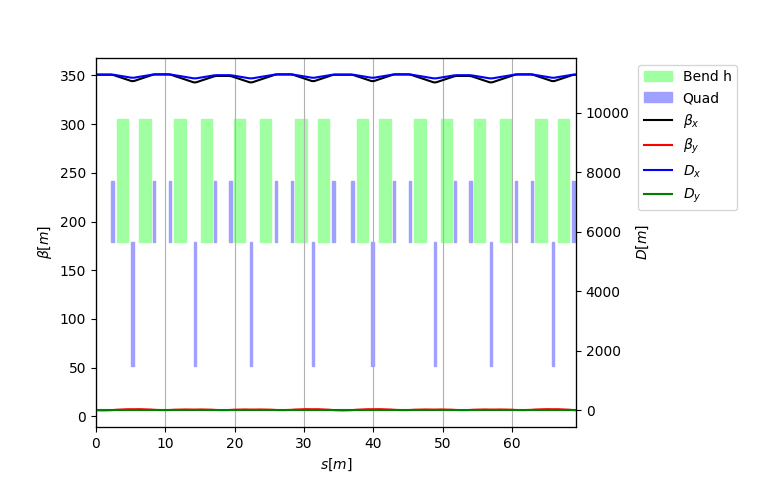

In [12]:
tw = ring.twiss4d(compute_chromatic_properties=False)
tw.plot()

### Match the tunes

In [19]:
opt_tune = ring.match(
    solve=False, # <- prepare the match without running it
    compute_chromatic_properties=False,
    method='4d',
    vary=[
        xt.Vary('kqfa', limits=(0, 10),  step=1e-3),
        xt.Vary('kqfb', limits=(0, 10),  step=1e-3),
        xt.Vary('kqd', limits=(-10, 0), step=1e-3),
    ],
    targets=[
        xt.TargetSet(qx=1.64, qy=1.72, tol=1e-6),
    ]
)

In [20]:
opt_tune.target_status()

Target status:               nalty = 6.8654e-06              
id state tag tol_met       residue   current_val    target_val description                         
0  ON    qx     True  -6.01704e-07          1.64          1.64 'qx', val=1.64, tol=1e-06, weight=10
1  ON    qy     True   3.30589e-07          1.72          1.72 'qy', val=1.72, tol=1e-06, weight=10


In [21]:
opt_tune.vary_status()

Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqfa           0      0.433675          10          0.01         0.001             1
1  ON        OK  kqfb           0      0.440806          10          0.01         0.001             1
2  ON        OK  kqd          -10     -0.582153           0         -0.02         0.001             1


In [22]:
opt_tune.run_jacobian(30)

                                             
Optimize - start penalty: 6.865e-06                          
Matching: model call n. 27 penalty = 6.8654e-06              
Optimize - end penalty:  6.8654e-06                            


In [23]:
opt_tune.target_status()

Target status:               nalty = 6.8654e-06              
id state tag tol_met       residue   current_val    target_val description                         
0  ON    qx     True  -6.01704e-07          1.64          1.64 'qx', val=1.64, tol=1e-06, weight=10
1  ON    qy     True   3.30589e-07          1.72          1.72 'qy', val=1.72, tol=1e-06, weight=10


In [18]:
opt_tune.vary_status()

Vary status:                 
id state tag met name lower_limit   current_val upper_limit val_at_iter_0          step        weight
0  ON        OK  kqfa           0      0.433675          10          0.01         0.001             1
1  ON        OK  kqfb           0      0.440806          10          0.01         0.001             1
2  ON        OK  kqd          -10     -0.582153           0         -0.02         0.001             1


### Inspect the optics

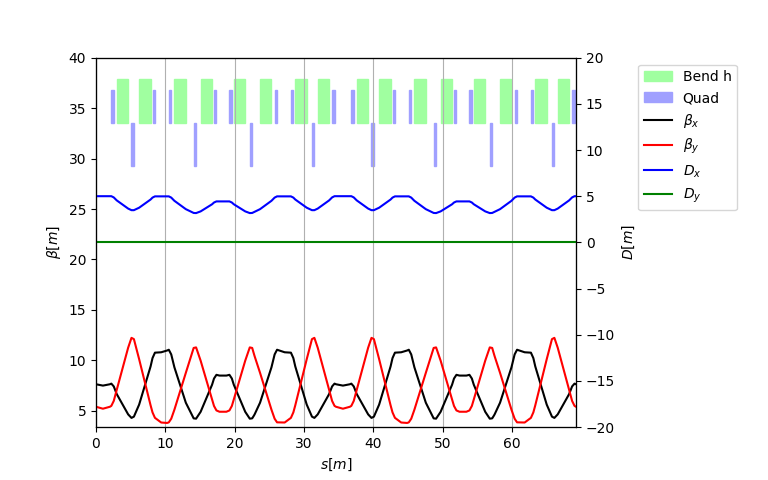

In [27]:
tw = ring.twiss4d()
pl = tw.plot()
pl.ylim(left_hi=40, right_lo=-20, right_hi=20,
        lattice_hi=1.5, lattice_lo=-7)

### Add constraint on dispersion at the center of the long straight sections

In [29]:
opt_disp = opt_tune.clone(
    add_targets=[
        xt.TargetSet(dx=0, at='mid.lss.0'),
        xt.TargetSet(dx=0, at='mid.lss.1'),
    ])

In [30]:
opt_disp.target_status()

Target status:               alty = 7.0719e+01              
id state tag          tol_met       residue   current_val    target_val description                                 
0  ON    qx              True  -6.01704e-07          1.64          1.64 'qx', val=1.64, tol=1e-06, weight=10        
1  ON    qy              True   3.30589e-07          1.72          1.72 'qy', val=1.72, tol=1e-06, weight=10        
2  ON    mid.lss.0_dx   False       5.00058       5.00058             0 ('dx', 'mid.lss.0'), val=0, tol=1e-09, w ...
3  ON    mid.lss.1_dx   False       5.00058       5.00058             0 ('dx', 'mid.lss.1'), val=0, tol=1e-09, w ...


In [31]:
opt_disp.run_simplex(100)

                                             
Optimize - start penalty: 70.72                             
Matching: model call n. 185 penalty = 9.3416e-04              
Optimize - end penalty:  0.000934159                            


### Inspect the optics

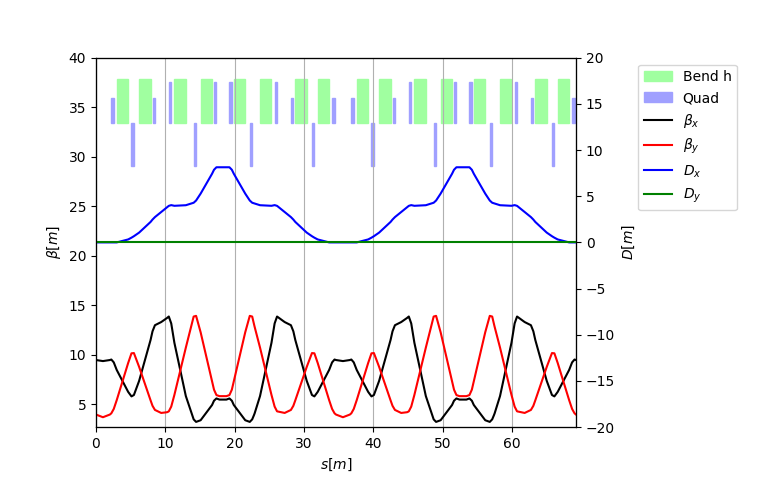

In [32]:
tw = ring.twiss4d()
pl = tw.plot()
pl.ylim(left_hi=40, right_lo=-20, right_hi=20,
        lattice_hi=1.5, lattice_lo=-7)

### Correct chromaticity

In [37]:
opt_chrom = ring.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['ksf', 'ksd'], step=1e-3),
    targets=xt.TargetSet(dqx=-0.01, dqy=-0.01, tol=1e-3, tag="chrom"))

In [38]:
opt_chrom.target_status()

Target status:               alty = 1.1997e+00              
id state tag   tol_met       residue   current_val    target_val description                          
0  ON    chrom   False     -0.562282     -0.572282         -0.01 'dqx', val=-0.01, tol=0.001, weight=1
1  ON    chrom   False      -1.05975      -1.06975         -0.01 'dqy', val=-0.01, tol=0.001, weight=1


In [39]:
opt_chrom.run_ls_dogbox(30)

In [41]:
opt_chrom.target_status()

Target status:               nalty = 1.4832e-08              
id state tag   tol_met       residue   current_val    target_val description                          
0  ON    chrom    True  -1.00289e-08         -0.01         -0.01 'dqx', val=-0.01, tol=0.001, weight=1
1  ON    chrom    True   1.09276e-08   -0.00999999         -0.01 'dqy', val=-0.01, tol=0.001, weight=1


### Save strengths to file

In [43]:
quad_strengths = opt_disp.get_knob_values()
quad_strengths

{'kqfa': 0.3370599718866199,
 'kqfb': 0.5462953318054187,
 'kqd': -0.5876756866422223}

In [47]:
sext_strengths = opt_chrom.get_knob_values()
sext_strengths

{'ksf': 1.1706435660167906, 'ksd': -4.29541544757396}

In [51]:
strengths = quad_strengths | sext_strengths
strengths

{'kqfa': 0.3370599718866199,
 'kqfb': 0.5462953318054187,
 'kqd': -0.5876756866422223,
 'ksf': 1.1706435660167906,
 'ksd': -4.29541544757396}

In [49]:
xt.json.dump(

Signature: xt.json.dump(data, file, indent=1)
Docstring: <no docstring>
File:      ~/xsuite_packages/xtrack/xtrack/json.py
Type:      function